# Cell 1 – Setup: Libraries and helper imports
We import the required Python libraries:

- **numpy, pandas** → numerical and tabular data handling
- **matplotlib, seaborn** → plotting graphs (confusion matrices)
- **LabelEncoder** → convert categorical features to numeric codes
- **train_test_split** → split dataset into training and testing sets

We also set a random seed to make results reproducible.

In [ ]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
np.random.seed(42)



# Cell 2 – Load dataset from Google Drive
Here we download the Mushroom dataset:

- If the file `mushroom.csv` is already present, skip downloading.  
- Otherwise, use the `gdown` library to fetch the dataset from Google Drive using its file ID.  
- The dataset is saved locally as `mushroom.csv`.


In [ ]:
# Step 2: Load dataset
url = 'https://drive.google.com/file/d/14kqJdXpuJzC0dLRk5ndHnNZc2osMdtmj/view?usp=sharing'

# Convert to the “download” link format:
file_id = url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"

output = 'mushrooms.csv'
gdown.download(download_url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=14kqJdXpuJzC0dLRk5ndHnNZc2osMdtmj
To: /content/mushrooms.csv
100%|██████████| 374k/374k [00:00<00:00, 10.5MB/s]


'mushrooms.csv'

# Cell 3 – Load data into pandas
We load the dataset into a pandas DataFrame and:

- Display the shape (number of rows and columns).  
- Show the first few rows.  
- Print the frequency of each class (`edible` vs `poisonous`).  


In [ ]:
# Cell 3 - Load dataset and show basic info
df = pd.read_csv('mushrooms.csv')
print("Shape:", df.shape)
display(df.head())
print("Class value counts:  ")
display(df['class'].value_counts())



Shape: (8124, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Class value counts:  


,count
class,
e,4208
p,3916


# Cell 4 – Encode categorical features
Since all features are categorical, we convert them into numerical codes using **LabelEncoder**.

- Each column gets its own encoder.  
- We save these encoders for later decoding back to human-readable values.  
- We also show the encoding for the target column `class` (e.g., `edible → 0`, `poisonous → 1`).  


In [ ]:
# Cell 4 - Encode categorical features with LabelEncoder (save encoders)
label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Show mapping for target 'class'
print("Class label mapping (encoded -> original):")
classes_encoded = list(range(len(label_encoders['class'].classes_)))
print(list(zip(classes_encoded, label_encoders['class'].classes_)))

# Prepare features and target arrays
X = df.drop(columns=['class']).values
y = df['class'].values



Class label mapping (encoded -> original):
[(0, 'e'), (1, 'p')]


# Cell 5 – Train/Test Split
We split the dataset into:

- **Training set = 80%**  
- **Test set = 20%**

We use `stratify=y` so the train and test sets have the same balance of `edible` and `poisonous` classes.  


In [ ]:
# Cell 5 - Train-test split (80/20) with stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (6499, 22)
Test size: (1625, 22)


# Cell 6 – Implement Naïve Bayes Training
We implement two training functions for Naïve Bayes:

1. **With Laplace smoothing**  
   - Uses `(count + 1) / (total + k)` where `k` is the number of possible feature values.  
   - Ensures no probability is zero.  

2. **Without Laplace smoothing**  
   - Uses raw frequency `(count / total)`.  
   - If a feature value never appeared for a class, probability = 0 (may hurt accuracy).  

Both functions return:
- Class priors  
- Conditional probabilities for each feature  
- Possible feature values  


In [ ]:
# Cell 6 - Helper functions to train Naive Bayes
def train_nb_with_laplace(X_tr, y_tr):
    n_samples, n_features = X_tr.shape
    classes = np.unique(y_tr)
    priors = {}
    cond_probs = {}
    # global value sets for each feature (from training data)
    feature_value_sets = [np.unique(X_tr[:, f]) for f in range(n_features)]
    k_values = [len(vals) for vals in feature_value_sets]
    for c in classes:
        X_c = X_tr[y_tr == c]
        count_c = X_c.shape[0]
        priors[c] = count_c / len(y_tr)
        cond_probs[c] = []
        for f in range(n_features):
            # counts for every possible value in feature_value_sets[f]
            vals = feature_value_sets[f]
            # count occurrences of each val in X_c[:, f]
            counts = {val: int(np.sum(X_c[:, f] == val)) for val in vals}
            # apply Laplace smoothing: (count + 1) / (count_c + k)
            k = k_values[f]
            probs = {val: (counts[val] + 1) / (count_c + k) for val in vals}
            cond_probs[c].append(probs)
    return classes, priors, feature_value_sets, cond_probs

def train_nb_no_smoothing(X_tr, y_tr):
    n_samples, n_features = X_tr.shape
    classes = np.unique(y_tr)
    priors = {}
    cond_probs = {}
    # value sets (used only to know space, but no smoothing applied)
    feature_value_sets = [np.unique(X_tr[:, f]) for f in range(n_features)]
    for c in classes:
        X_c = X_tr[y_tr == c]
        count_c = X_c.shape[0]
        priors[c] = count_c / len(y_tr)
        cond_probs[c] = []
        for f in range(n_features):
            vals, counts = np.unique(X_c[:, f], return_counts=True)
            probs = {val: (count / count_c) for val, count in zip(vals, counts)}  # no +1
            cond_probs[c].append(probs)
    return classes, priors, feature_value_sets, cond_probs



# Cell 7 – Prediction functions
We define functions to predict labels:

- **predict_single:** Predicts one sample by calculating the log of class prior × feature probabilities.  
- **predict:** Predicts an array of samples.  

If a feature value is unseen:
- With smoothing → assigns a small probability.  
- Without smoothing → assigns 0 probability (`-inf` in log space), falling back to the majority class if all classes fail.  


In [ ]:
# Cell 7 - Prediction functions (log-space); fallback if all -inf
def predict_single(x, classes, priors, feature_value_sets, cond_probs, smoothing=True):
    posteriors = {}
    for c in classes:
        logp = np.log(priors[c])
        for f, val in enumerate(x):
            probs_dict = cond_probs[c][f]
            if val in probs_dict:
                p = probs_dict[val]
                # guard: if p == 0 in no-smoothing, set to -inf
                if p == 0:
                    logp = -np.inf
                    break
                logp += np.log(p)
            else:
                # value unseen for this class
                if smoothing:
                    logp += np.log(1e-12)
                else:
                    logp = -np.inf
                    break
        posteriors[c] = logp
    best_class = max(posteriors, key=lambda k: posteriors[k])
    if np.isneginf(posteriors[best_class]):
        best_class = max(priors, key=lambda k: priors[k])
    return best_class

def predict(X, classes, priors, feature_value_sets, cond_probs, smoothing=True):
    return np.array([predict_single(x, classes, priors, feature_value_sets, cond_probs, smoothing) for x in X])



# Cell 8 – Train both models
We train two models using the training set:

- **Naïve Bayes WITH Laplace smoothing**  
- **Naïve Bayes WITHOUT Laplace smoothing**  

We then confirm both models learned the same class labels.  


In [ ]:
# Cell 8 - Train both models
classes_s, priors_s, feature_value_sets_s, cond_probs_s = train_nb_with_laplace(X_train, y_train)
classes_ns, priors_ns, feature_value_sets_ns, cond_probs_ns = train_nb_no_smoothing(X_train, y_train)

# quick sanity check - classes should match
assert np.array_equal(classes_s, classes_ns)
print("Classes:", classes_s)



Classes: [0 1]


# Cell 9 – Test set predictions
We generate predictions for the **test set** using:

- The smoothed model  
- The non-smoothed model  

The predictions are stored separately for comparison.  


In [ ]:
# Cell 9 - Predictions on test set
y_pred_smooth = predict(X_test, classes_s, priors_s, feature_value_sets_s, cond_probs_s, smoothing=True)
y_pred_nosmooth = predict(X_test, classes_ns, priors_ns, feature_value_sets_ns, cond_probs_ns, smoothing=False)



# Cell 10 – Confusion matrix and metrics functions
We implement evaluation helpers:

1. **confusion_matrix_manual:** Builds a confusion matrix (actual vs predicted counts).  
2. **compute_metrics_from_cm:** Calculates:
   - Accuracy  
   - Precision, Recall, and F1 for each class  
   - Macro averages (average across classes)

This avoids using sklearn metrics and relies only on formulas.  


In [ ]:
# Cell 10 - Build confusion matrix function and metrics (manual)
def confusion_matrix_manual(y_true, y_pred, classes):
    n = len(classes)
    cls_to_idx = {c:i for i,c in enumerate(classes)}
    cm = np.zeros((n,n), dtype=int)
    for t,p in zip(y_true, y_pred):
        cm[cls_to_idx[t], cls_to_idx[p]] += 1
    return cm

def compute_metrics_from_cm(cm, classes, class_names=None):
    n = cm.shape[0]
    tot = cm.sum()
    # per-class metrics
    per_class = {}
    for i, c in enumerate(classes):
        TP = cm[i,i]
        FP = cm[:,i].sum() - TP
        FN = cm[i,:].sum() - TP
        TN = tot - TP - FP - FN
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        per_class[c] = {
            'TP':TP, 'FP':FP, 'FN':FN, 'TN':TN,
            'precision':precision, 'recall':recall, 'f1':f1
        }
    accuracy = np.trace(cm) / tot
    # macro averages
    macro_precision = np.mean([per_class[c]['precision'] for c in classes])
    macro_recall = np.mean([per_class[c]['recall'] for c in classes])
    macro_f1 = np.mean([per_class[c]['f1'] for c in classes])
    return {
        'confusion_matrix': cm,
        'per_class': per_class,
        'accuracy': accuracy,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1
    }

# Cell 11 – Evaluate both models
We evaluate both Naïve Bayes models:

- Build their confusion matrices  
- Compute accuracy, precision, recall, and F1 scores  
- Map class numbers back to original labels (`edible`, `poisonous`)  


In [ ]:
# Cell 11 - Evaluate both models
cm_s = confusion_matrix_manual(y_test, y_pred_smooth, classes_s)
metrics_s = compute_metrics_from_cm(cm_s, classes_s)

cm_ns = confusion_matrix_manual(y_test, y_pred_nosmooth, classes_ns)
metrics_ns = compute_metrics_from_cm(cm_ns, classes_ns)

# Helper to print nicely using original class labels
orig_class_names = list(label_encoders['class'].classes_)
print("Original class names order:", orig_class_names)



Original class names order: ['e', 'p']


# Cell 12 – Print comparison summary
We print a detailed comparison of both models:

- Overall accuracy  
- Macro-averaged precision, recall, and F1  
- Confusion matrix  
- Per-class metrics (decoded to edible/poisonous)

This allows us to compare how Laplace smoothing impacts performance.  


In [ ]:
# Cell 12 - Print summary comparison
def print_summary(metrics, label):
    print(f"=== {label} ===")
    print("Accuracy:", round(metrics['accuracy'], 6))
    print("Precision:", round(metrics['macro_precision'], 6))
    print("Recall:", round(metrics['macro_recall'], 6))
    print("F1:", round(metrics['macro_f1'], 6))
    print("Confusion Matrix:\n", metrics['confusion_matrix'])

print("\n")
print_summary(metrics_s, "Naive Bayes WITH Laplace smoothing")
print_summary(metrics_ns, "Naive Bayes WITHOUT Laplace smoothing")





=== Naive Bayes WITH Laplace smoothing ===
Accuracy: 0.945846
Precision: 0.950849
Recall: 0.944119
F1: 0.945481
Confusion Matrix:
 [[835   7]
 [ 81 702]]
=== Naive Bayes WITHOUT Laplace smoothing ===
Accuracy: 0.994462
Precision: 0.994364
Recall: 0.994566
F1: 0.994455
Confusion Matrix:
 [[835   7]
 [  2 781]]


# Cell 13 – Plot confusion matrices
We plot the confusion matrices side by side:

- **Left:** With Laplace smoothing  
- **Right:** Without Laplace smoothing  

This visualization highlights differences in misclassifications between the two models.  


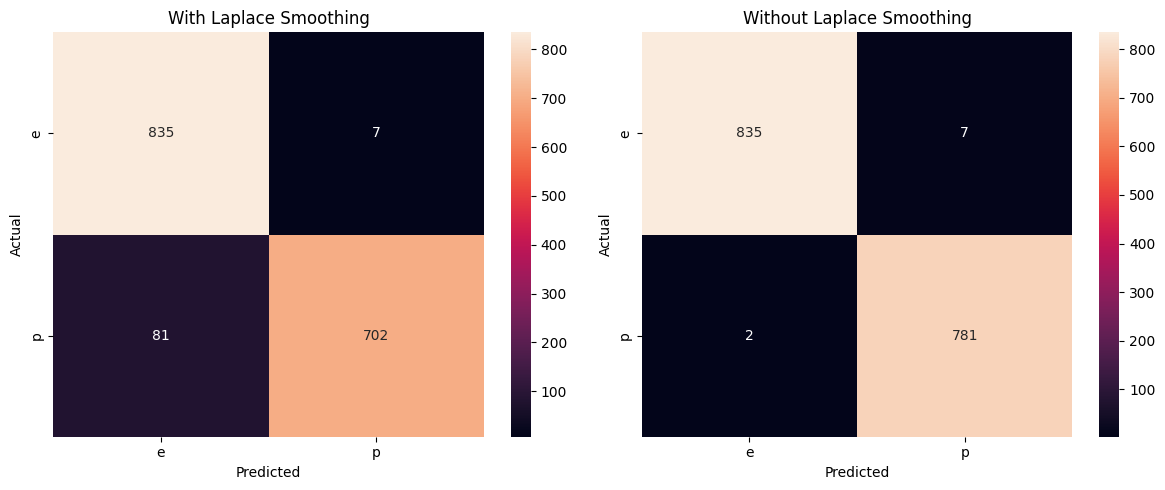

In [ ]:
# Cell 13 - Plot confusion matrices side by side
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(metrics_s['confusion_matrix'], annot=True, fmt='d', ax=axes[0],
            xticklabels=orig_class_names, yticklabels=orig_class_names)
axes[0].set_title('With Laplace Smoothing')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')

sns.heatmap(metrics_ns['confusion_matrix'], annot=True, fmt='d', ax=axes[1],
            xticklabels=orig_class_names, yticklabels=orig_class_names)
axes[1].set_title('Without Laplace Smoothing')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()
